<a href="https://colab.research.google.com/github/YangJunsuck-korea/regular/blob/master/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!nvidia-smi

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Dropout, UpSampling2D, add, Conv2DTranspose, Conv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
import os, cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Encoder
input_img = Input(shape=(256, 256, 3))

l1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)

l4 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)
encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)    

In [ ]:
#Decoder
l8 = UpSampling2D()(l7)
l9 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l10, l5])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])
#channel = 3, for RGB
decoded = Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

In [ ]:
autoencoder.summary()

In [ ]:
path_1 = "/content/drive/My Drive/resize"
path_2 = "/content/drive/My Drive/down"
valid_images = [".jpg",".jpeg",".png",".tga"]

print(len(os.listdir(path_1)), len(os.listdir(path_2)))

In [ ]:
'''
def get_image(path):
    x = []
    index = 0
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        image = cv2.imread(os.path.join(path, f))
        x.append(image)
        index += 1
        if index == 10:
            break
    return x
'''

In [ ]:
def get_img(path, num):
    x = []
    for i in range(1, len(os.listdir(path))):
        image = cv2.imread(path + '/%06d.jpg' % i, cv2.IMREAD_COLOR)
        x.append(image)
        if i == num:
          break
    return x

In [ ]:
x_train_n, x_train_down = get_img(path_1, 5000), get_img(path_2, 5000)
x_train_n = np.array(x_train_n)
np.save('/content/drive/My Drive/x_n', x_train_n)
x_train_down = np.array(x_train_down)
np.save('/content/drive/My Drive/x_d', x_train_down)
x_train_n.shape

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.fit(x_train_down, x_train_n, epochs=20, batch_size=10, shuffle=True, validation_split=0.20)
encoder.save('encoder.h5')
autoencoder.save('autoencoder.h5')

In [ ]:
model_au = load_model("/content/drive/My Drive/autoencoder.h5")
model_en = load_model("/content/drive/My Drive/encoder.h5")

In [ ]:
x_d = x_train_down[0:2]

In [ ]:
encoded_imgs = model_en.predict(x_d)
print(encoded_imgs.shape)

(2, 64, 64, 256)


In [ ]:
srl = model_au.predict(x_d)
print(srl.shape)

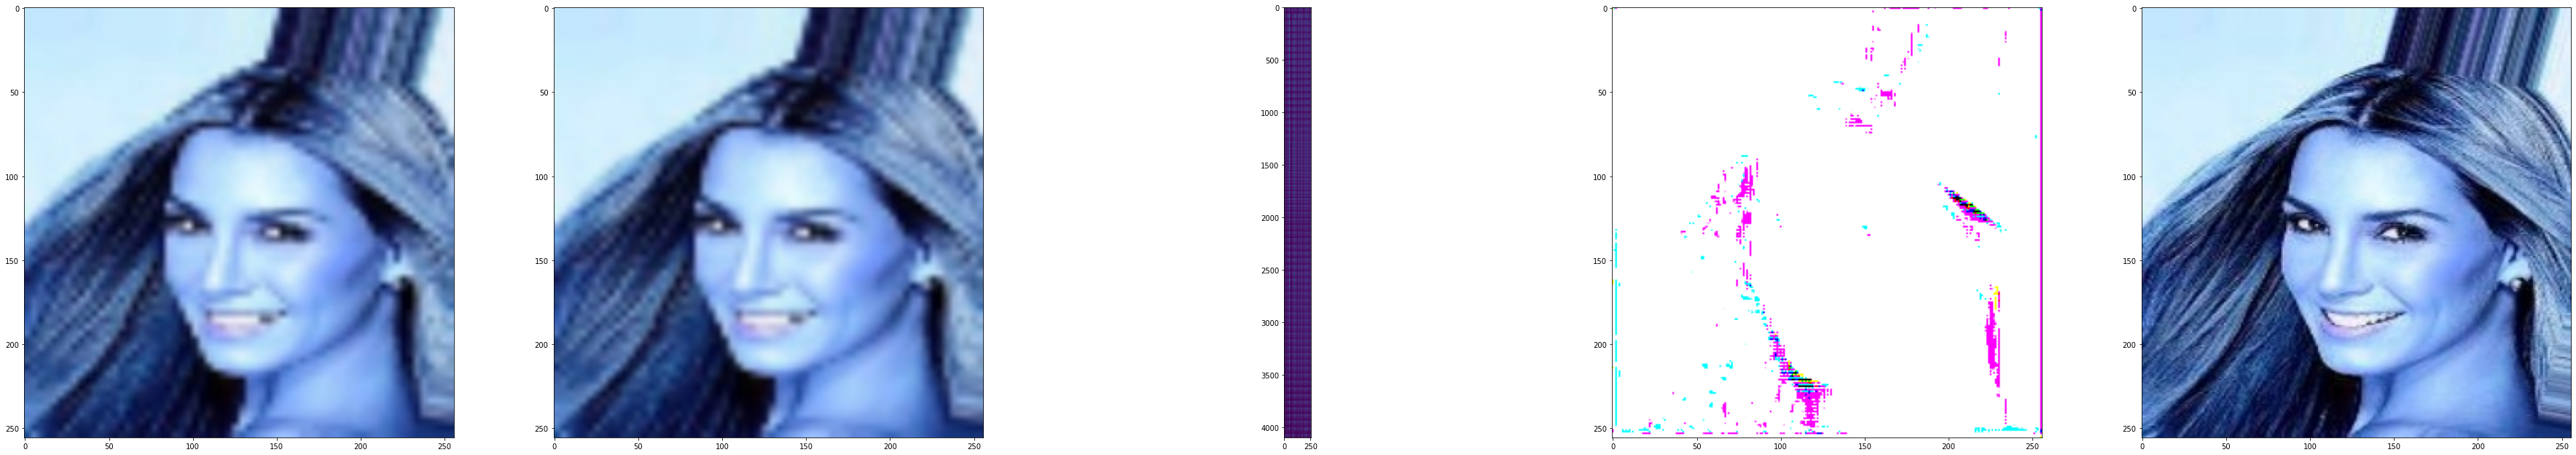

In [ ]:
image_index = 0
i = 1
plt.figure(figsize=(128, 128))
ax = plt.subplot(10,10,i)
plt.imshow(x_d[image_index])
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(x_train_down[image_index], interpolation="bicubic")
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(encoded_imgs[image_index].reshape((64*64, 256)))
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(srl[0].astype(np.uint8))
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(x_train_n[image_index])
plt.show()